In [1]:
from IPython.core.display import HTML
HTML("""
<style>
/* Custom CSS for Jupyter Notebook Headings with moderate colors and rounded corners */
h1 {
    background-color: #CDB2F6;
}

h2 {
    background-color: #EAF185;
    display: inline;

}

h3 {
    background-color: #BDFFF9;
    display: inline;
}

h4 {
    background-color: #FCC7C7;
    display: inline;
}
</style>
""")


In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from custom_slangs import abbreviations # Imported abbreviation lookup from custom file
from imblearn.under_sampling import RandomUnderSampler

import spacy
from spacy import displacy
import contractions

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertTokenizer

/Users/jaxxsulav/Projects/Loyalist/Sem3/NLP/Tweet Sentiment RNN/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# !python -m spacy download en_core_web_lg
NER = spacy.load("en_core_web_sm")

In [4]:
df = pd.read_csv("./SentimentData.csv", encoding='latin-1')
df.head()

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [5]:
pd.set_option('display.max_colwidth', None)

# Helpers:

In [6]:
def handle_specials(t: str) -> str:
    ## Ord(character) will give you the integer value for that character. Since standard ASCII range is from
    # 0 to 127, any thing after that will contribute to emojis, and weird characters like "Å© ‚Å¶, üòÇ"
    #  This is Apple logo
    t = ''.join([x for x in t if ord(x) < 128])
    t = re.sub(r'http\S+|www\S+|https\S+', '', t) # Remove Links
    t = re.sub("@[A-Za-z0-9_]+","", t) # Remove mentions @Juggernaut
    t = re.sub("#[A-Za-z0-9_]+","", t) # Remove hashtags #Necromancer
    
    # We have tweets like -> FREEDOM\nFREEDOM\nFREEDOM \n\nBUSY BUSY BUSY\n -> We need to remove "\n"
    # We also have to deal with the trailing dpulication problem here.
    t = t.strip().replace('\n', '') # Replace \n with whitespace
    t = re.sub(r'\b(\w+)( \1\b)+', r'\1', t, flags=re.IGNORECASE) # Reduce any trailing words
    
    # Only keep english letter(Cap and small) & numbers 
    # We also should not remove aphostrophe('), because we need them in handling contractions. (won't, can't)
    # But we also notice that we have structure 'create chaos', 'massive and amazing', where the
    # aphostrophe does not mean contractions so we need to remove them after contraction handling step.
    t = re.sub(r"[^a-zA-Z0-9'\s]", ' ', t)
    t = re.sub(r'\s+', ' ', t).strip() # Convert all the trailing whitespaces to one whitespace
    return t


def convert_slangs(tweet: str) -> str:
    # Split -> lookup & replace -> Join 
    words = tweet.split()
    modified_words = [abbreviations[word.lower()] if word.lower() in abbreviations else word for word in words]
    return ' '.join(modified_words)

def count_words(tweets: pd.Series) -> int:
    return tweets.apply(lambda x: len(str(x).split())).sum()

def NER_detection(tweet:str) -> list[str]:
    ner = NER(tweet)
    entities = [entity.text for entity in ner.ents]
    return entities

def fix_contractions(tweet:str) -> str:
    return contractions.fix(tweet)

# Cleaning, Preprocessing and Observations

## Clean

In [7]:
cleaned_df = df.dropna()
cleaned_df = cleaned_df.drop_duplicates()
cleaned_df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

## Combine Sentiments

In [8]:
sentiments = df['Sentiment'].value_counts()
sentiments

Sentiment
Strong_Pos    233700
Neutral        77016
Mild_Pos       64004
Strong_Neg     42556
Mild_Neg       34056
Name: count, dtype: int64

In [9]:
cleaned_df = cleaned_df.copy()
cleaned_df['Sentiment'] = cleaned_df['Sentiment'].replace({
    'Mild_Pos': 'Positive',
    'Strong_Pos': 'Positive',
    'Mild_Neg': 'Negative',
    'Strong_Neg': 'Negative'
})

## Value Counts

In [10]:
sentiments = cleaned_df['Sentiment'].value_counts()
sentiments

Sentiment
Positive    297674
Neutral      77012
Negative     76609
Name: count, dtype: int64

<Axes: xlabel='Sentiment', ylabel='Count'>

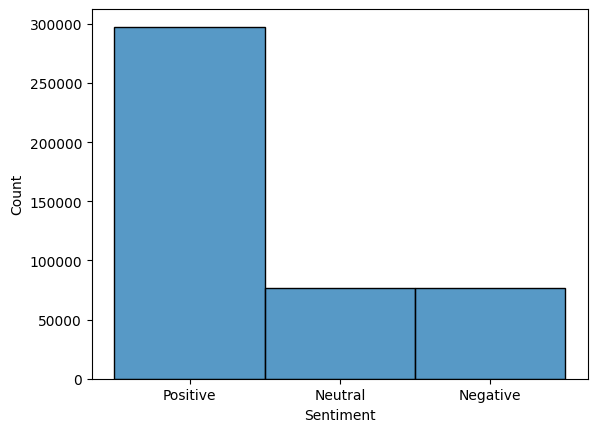

In [11]:
sns.histplot(cleaned_df["Sentiment"])

### Unbalanced data -> Needs to be balanced after train test split. Balancing only applied on training set.

- We have to balance the data just for training set. This is to prevent it from data leakage.
- Data leakage is when we have some information about testing data in training data which contradicts with the purpose of evaluation.
- When we modify the whole dataset before splitting, if we are filling artificial data points, we will be using those points in evaluation too.
- The goal here is to keep the testing data untouched - as original as possible, okay!

### Handling special characters because as seen in the sample below, we have links, mentions, hashtags and other special characters.

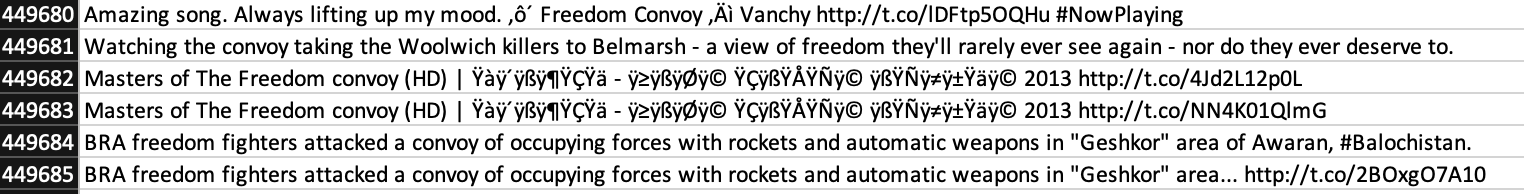

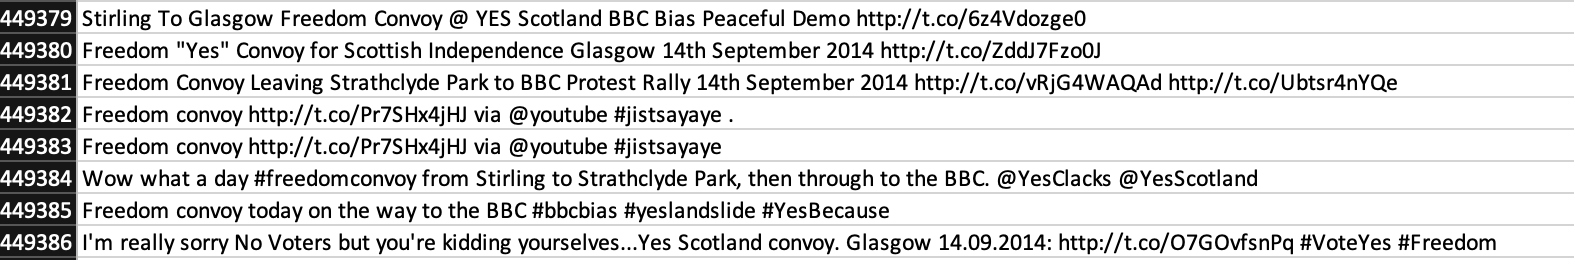

##  Non-Grams: Observations and Corrections

In [12]:
#TODO: Remove aphostrophe after contraction handling.
cleaned_df['Tweet'] = cleaned_df['Tweet'].apply(handle_specials)

# THIS IS HOW HYPOCRITCAL TURDEAU CASTRO IS

In [13]:
# cleaned_df.sample(n=5)

### We noticed that after the characters removal process, some rows are just whitespaces, let's remove them


In [14]:
cleaned_df = cleaned_df[(cleaned_df['Tweet'].str.strip() != '')]
cleaned_df.reset_index(drop=True, inplace=True) # Some rows have been removed, need to reset index.
cleaned_df.shape

(440738, 2)

In [15]:
cleaned_df.sample(n=2)

,Tweet,Sentiment
286552,Truckers are real life folk heroes This is a bit of a read but well worth it America truckers mobilized in Dec 1973,Positive
409680,Through fundraising to support science and research in Terrys name people survive cancer when they never would before This is a disgrace,Negative


## Handling Slang and Abbreviations using lookups:

In [16]:
count_words(cleaned_df["Tweet"])

9777402

In [17]:
cleaned_df['Tweet'] = cleaned_df['Tweet'].apply(convert_slangs)

In [18]:
count_words(cleaned_df["Tweet"])

9804116

### Words count is 26882 higher than before, that means we have unfolded some slangs here which are in the dictionary lookup.

## NER detection and spell correction

In [19]:
cleaned_df.head()

,Tweet,Sentiment
0,Happy Anniversary The Day the FreeDUMB Died In the tune of Don McLean's American Pie,Positive
1,Happy Anniversary The Day the FreeDUMB Died In the tune of Don McLean's American Pie,Positive
2,Happy Anniversary The Day the FreeDUMB Died In the tune of Don McLean's American Pie,Positive
3,Happy Anniversary The Day the FreeDUMB Died In the tune of Don McLean's American Pie,Positive
4,Happy Anniversary The Day the FreeDUMB Died In the tune of Don McLean's American Pie,Positive


### As we can see, after cleaning, we can see some duplicates form up due to removing of some special characters. Let's remove them

In [20]:
cleaned_df.shape

(440738, 2)

In [21]:
cleaned_df = cleaned_df.drop_duplicates()

In [22]:
cleaned_df.shape

(364970, 2)

In [23]:
cleaned_df.head()

,Tweet,Sentiment
0,Happy Anniversary The Day the FreeDUMB Died In the tune of Don McLean's American Pie,Positive
8,Freedom Convoy as InkBlot Test,Positive
13,Well its pretty easy to see what their agenda is and Pierre has remained silent on the issues and he never actually fought for the convoy just did a photo op,Positive
23,You Belong In Jail,Neutral
27,Your head is so far up Trudeaus ass you can see what he had for lunch Trudeau doesnt debate he will never answer an unscripted question The fringe minoritywas the millions who supported the Freedom C,Positive


In [24]:
# %%time
# entities = cleaned_df["Tweet"].apply(NER_detection)

### Too much time taken, will skip for now...

## Contractions

In [25]:
count_words(cleaned_df["Tweet"])

8858338

In [26]:
cleaned_df["Tweet"] = cleaned_df["Tweet"].apply(fix_contractions)

In [27]:
count_words(cleaned_df["Tweet"])

8977374

### There are 119048 more words than before: Implies, contractions are expanded. Also structures like 'create chaos', 'massive and amazing', where the aphostrophe does not mean contractions are intact. So Let's remove them finally.

In [28]:
cleaned_df["Tweet"] = cleaned_df["Tweet"].replace("'", "")

In [29]:
cleaned_df.sample(n=5)

,Tweet,Sentiment
139680,Reports of Canadians praising Macrons victory as a win for democracy amp centrist is as nuanced as the foreign reports made on the freedom convoy It seems that unless you follow the politics of a country you,Positive
336791,the pic i saw had them in front of a thank you freedom convoy sign,Positive
117692,Where is a trucker freedom convoy when you need it,Positive
265317,After getting dumped on a Homegoods rug on the grass Shanae dove into the falls was reborn from the mist and swam across Lake Erie to the Freedom Convoy where she convinced an anti vaxx trucker she was Meryl Streep,Positive
74208,Wow are you really comparing the freedom convoy to the civil rights movement Yikes dude check your privilege,Positive


## Stop-Words removal: Can we??

` => Stop words like [not, but] and so on are crucial in determining the sentiment as it tends to change the meaning of the preceding words. `

`=> If we use any library to remove stop words, it will remove all of these relavant piece of information.`

## We can't perform stop-word removal using libraries

` => Let's make a custom stop words which should not impact the sentiment and apply in our dataset.`

In [30]:
custom_stopwords = ['the', 'a', 'of', 'and', 'to', 'in', 'is', 'it', 'is', 'am', 'are', 'was', 'were', 'an', 'in', \
                'at' , 'you', 'for', 'i', 'on', 'they', 'he', 'him', 'his', 'her', 'himself', 'it', 'they', 'them',\
                'this', 'that', 'these', 'those', 'be', 'by']

def stopwords_removal(tweet):
    # Split -> Filter -> Join
    words = tweet.lower().split() # Lowercased for stopwords
    filtered_words = [w for w in words if w not in custom_stopwords]
    filtered_tweet = ' '.join(filtered_words)
    return filtered_tweet

cleaned_df['Tweet'] = cleaned_df['Tweet'].apply(stopwords_removal)

In [31]:
count_words(cleaned_df["Tweet"])

6512637

### We have reduced the words count by significant amount from 8977374 words to 6512637 words. 

In [32]:
cleaned_df.to_csv("./cleaned_sentiment.csv", index=False)

In [33]:
cleaned_df.sample(n=3)

,Tweet,Sentiment
194873,did we ask crosby about feelings freedom convoy just saying americans bit crazy eh,Positive
368683,dear freedom convoy if get sick do expect receive medical treatment if so then shut up mask up,Positive
261986,2009 howland received conditional discharge after threatened principal new brunswick elementary school when stopped daily singing o canada n b business owner says donated 75 000 freedom convoy cbc news,Neutral


# Transformer Architecture (non-causal -> no masking):
- Tokenize and generate embedings with positional encodings for each tweet -> Embedding Layer (learnable)
- Self-Attention (Multi-Heads) with concatenated outputs -> Attention layer parallel computations
- Creation of transformer block having multi-head attentions and fully connected and normalization layers -> Transformer block
- Stack non-causal transformer blocks where each transformer gets input from previous transformer block -> Transformer architecture
- Get output from last transformer block and perform pooling(max, avg...) to get sentiment -> Output layer
- `Next:`
- Calculate loss and backpropagate -> Training
- Evaluate -> Evaluation

## 1. Embedding Layer with Sinusodial Positional Encodings

### Embedding Layer

In [34]:
class TokenEmbeddingLayer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings):
        ''' 
        te.state_dict() will contain randomly initialized weight vectors which the model learns to calculate the word embeddings
        embedding_dim: length of dimension of embedding of each word vector
        num_embeddings: vocab_size
        '''
        super(TokenEmbeddingLayer, self).__init__()
        # nn.Embedding gives OrderedDict which is something like lookup table(as it remembers the order of the items) 
        # This will help to get embeddings for each indices [0, 1, 2, 3], 0th word, 1st word... in a sequence
        self.te = nn.Embedding(embedding_dim=embedding_dim, num_embeddings=num_embeddings)
        self.embedding_dim = embedding_dim

    def forward(self, x):
        # We divide the elements in weight matrix by sqrt of embedding dimension lenght to scale
        return self.te(x) * math.sqrt(self.embedding_dim)
    

In [35]:
nn.Embedding(embedding_dim=4, num_embeddings=2).state_dict() # Randomly initialized

OrderedDict([('weight',
              tensor([[ 0.5587,  0.0627, -0.5892, -0.5334],
                      [-1.0134,  1.3063,  0.0712, -0.0441]]))])

### Embedding Layer element wise addition with Sinusodial Positional Encodings

#### Slightly modified version of the formula from "Attention is all you need" paper

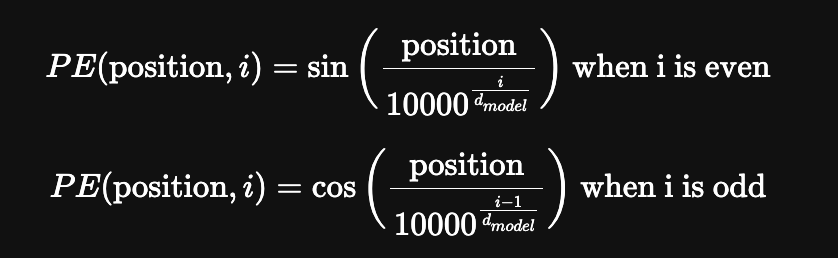

In [36]:
class SinusoidalPositionalEncoding(nn.Module): 
    '''
    For each element in word embedding vector, we will use sine if the element of vector is even and cos if the element is odd.
    We calculate odd and even positional encoding vectors and then interleave the encoding vectors using torch.stack()
    Then we can flatten the stacked encodings to get the positional encoding containing even and odd encodings.
    '''
    def __init__(self, pe_dimensions, max_seq_len):
        super(SinusoidalPositionalEncoding, self).__init__()

        # This will create a tensor starting from range 0 to dimension of embedding with skip of 2.
        # Since it starts from 0, this will be our even elements vector -> tensor([0., 2., 4.])
        i = torch.arange(0, pe_dimensions, 2).float() # The pe_dimension will have same shape as word embedding
                                                      # as it needs to be added to the word embedding vector
        
        # As the example shown in cell below, We will just use the value from i from even case because 
        # divisor from both odd and even cases will be the same vector.
        divisor = torch.pow(10000, i/pe_dimensions)

        # The unsqueeze(1) will convert [0, 1, 2] to [[0], [1], [2]]
        # This new shape is necessary for something called boadcasting in pytorch in our division step
        # where each element from pos is divided by divisor.
        pos = torch.arange(0, max_seq_len).unsqueeze(1) # These elements are the positions of words

        # Dividing as done in formulae
        pe_even = torch.sin(pos/divisor)
        pe_odd = torch.cos(pos/divisor)

        # Stack will interleave two vectors, i.e. [[a, c, e], [b, d, f]] -> [[a, b], [c, d], [e, f]]
        # which we can flatten to get [a, b, c, d, e, f] which will be our positional encoding for a word
        pe_stacked = torch.stack([pe_even, pe_odd], dim=2) # stack along the 2nd dimension -> [[a]] -> [1st[2nd]]
        pe = torch.flatten(pe_stacked, start_dim=1, end_dim=2) # There are only 2 dimensions odd and even
                                                              # so, first will be 1 and last will be 2

        # Now, the positional embedding is deterministic as we can calculate it using the formulae above 
        # and we do not need to train it because we can generate theoritically infinite length of vector
        # using these sinusodial functions without duplicating. So, we make it a non-parameter(not-learnable) i.e.
        # it will not be updated by optimizer. It will be saved in buffer and loaded with the model as it's part.
        self.register_buffer("pe", pe)

    def forward(self, x):
        # We need to expand self.pe because if x.shape is [1, 3, 2] self.pe.shape will be [3,2]
        # So, we expand self.pe with the batch size value which is the first element of x
        # -1, -1 in expand ensures that the previous shape is maintained for those positions
        # So, for above example, it will [3, 2] will be changed to [1, 3, 2].
        # Since the positional encodings doesn't change, we will not compute gradient in this step
        pe_expanded = self.pe.expand(x.size(0), -1, -1).requires_grad_(False) 
        return (x + pe_expanded)


#### The reason for only using one denominator for dividing position/pow(10000, i/d_model)
> The even and odd denominator have same values as seen below:

In [37]:
e_i = torch.arange(0, 6, 2).float()
even_divisor = torch.pow(10000, e_i/6)
o_i = torch.arange(1, 6, 2).float()
odd_divisor = torch.pow(10000, (o_i-1)/6)
(e_i, o_i, even_divisor, odd_divisor)

(tensor([0., 2., 4.]),
 tensor([1., 3., 5.]),
 tensor([  1.0000,  21.5443, 464.1590]),
 tensor([  1.0000,  21.5443, 464.1590]))

#### Odd and Even encodings: (max_seq_len = 5, pe_dimensions = 6)

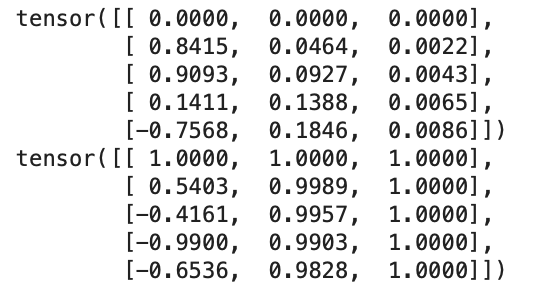

#### Interleaven encodings (torch.stack):

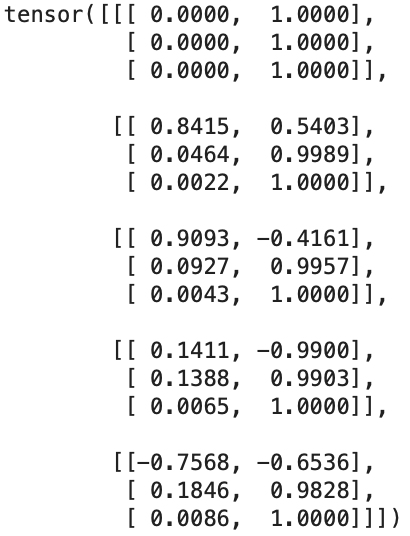

#### Flattened encodings: -> Final positional encodings for words

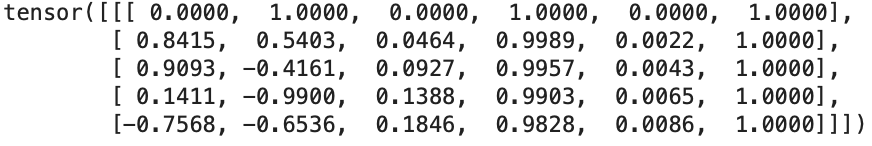

## 2. Self-Attention Module (Multi-headed)

# Preprocessing, Tokenization and Data Loading:

## Preprocessing part 2

### Let's start with 20000 random samples from the dataset to reduce training time and complexity. We will increase this after getting model results.

In [38]:
new_df=cleaned_df.sample(60000, random_state=6828)

In [39]:
new_df["Sentiment"].value_counts()

Sentiment
Positive    39487
Negative    11354
Neutral      9159
Name: count, dtype: int64

In [40]:
# new_df.to_csv("./new_sentiment.csv", index=False)

### Encode Sentiment column

In [41]:
label_encoder = LabelEncoder()
new_df['Sentiment'] = label_encoder.fit_transform(new_df['Sentiment'])

### Split the data into train, test and validation sets. Since this is an unbalanced class as seen above, we will stratify in this step and undersample "Positive class" in training dataset only.

In [42]:
train_val_df, test_df = train_test_split(new_df, test_size=0.1, stratify=new_df['Sentiment'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['Sentiment'], random_state=42)

train_df.shape, test_df.shape, val_df.shape

((48600, 2), (6000, 2), (5400, 2))

#### We have 48600, 6000 and 5400 data in train, test and validation sets.

### Balancing(Undersampling) training data

In [43]:
# Split features and labels -> RandomUnderSample -> Add both to new dataset.
X_train = train_df[['Tweet']] 
y_train = train_df['Sentiment']

undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)
train_df = pd.DataFrame(X_undersampled, columns=['Tweet'])
train_df['Sentiment'] = y_undersampled

train_df["Sentiment"].value_counts(), train_df.shape

(Sentiment
 0    7419
 1    7419
 2    7419
 Name: count, dtype: int64,
 (22257, 2))

## Tokenization and Datatype Conversion

#### We have to convert data to a "torch.utils.data.Dataset" object to be able to create the data loaders for our transformer.

### Using Bert Tokenizer:

In [44]:
class OurSentimentDataset(Dataset):
    ''' Inherits from "torch.utils.data.Dataset"
        We will convert out pandas dataframe to torch Dataset here
        Except from that, we will also tokenize, pad the smaller sized datapoints and
        truncate the longer sequence than max_length.
        We will return tokenized data as ids, attention mask to differentiate between
        padded data and actual data, and the labels tensors.
    '''
    def __init__(self, df, tokenizer, max_seq_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        tweet = self.df.iloc[idx]['Tweet'] # Get tweet 
        sentiment = self.df.iloc[idx]['Sentiment'] # Get Sentiment (label)
        # Tokenization of tweet, padding smaller tweets to max_seq_len, truncating larger tweets & return output tensor as pytorch tensor
        tokenized_ids = self.tokenizer(tweet, max_length=self.max_seq_len, padding='max_length', truncation=True, return_tensors="pt")
        
        return {
            'tweets_tokenized_ids': tokenized_ids['input_ids'].flatten(), # tokenized tweets as ids
            'padding_mask': tokenized_ids['attention_mask'].flatten(), # padding mask to know which token groups are padded
            'sentiment_labels': torch.tensor(sentiment, dtype=torch.long) # Labels for training
        }

### Unfortunately, BERT has 30522 vocab size which is computationally expensive. We can modify it but it is quite hard to sync the output with our embedding layer input as we are using nn.Embedding in our embedding layer. So, let's use tokenizer from pytorch itself. We have to handle padding and truncations ourself here.

In [45]:
class OurSentimentDataset(Dataset):
    def __init__(self, df, tokenizer, vocab, max_seq_len):
        self.df = df
        self.max_seq_len = max_seq_len
        self.tokenizer = tokenizer
        self.vocab = vocab
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        tweet = self.df.iloc[idx]['Tweet']
        sentiment = self.df.iloc[idx]['Sentiment']
        
        tokenized_tweet = self.tokenizer(tweet)
        # Need to convert into indices because vocab is the lookup table.
        # So, we tokenize words and map those words to numbers in vocab.
        indexed_tokens = [self.vocab[token] for token in tokenized_tweet]
        
        # We have to pad the indexec tokens to maintain the same input size.
        # If the length of the words are less than max_seq_len,
        # we add (max words - number of words in sequence) <pad> indices from vocab.
        if len(indexed_tokens) < self.max_seq_len:
            indexed_tokens += [self.vocab["<pad>"]] * (self.max_seq_len - len(indexed_tokens))
        # For truncation, if the number of words in a sequence is larger, we just slice it to max
        else:
            indexed_tokens = indexed_tokens[:self.max_seq_len]
        
        # Attention mask (1 for real tokens, 0 for padding) - Just creating because we had this concept from Bert Tokenizer
        attention_mask = [1 if token != self.vocab["<pad>"] else 0 for token in indexed_tokens]
        
        return {
            'tweets_tokenized_ids': torch.tensor(indexed_tokens, dtype=torch.long),
            'padding_mask': torch.tensor(attention_mask, dtype=torch.long),
            'sentiment_labels': torch.tensor(sentiment, dtype=torch.long)
        }


### What value for maximum sequence length ??

#### We can use values like 128, 256, 512. Bert must have limitation upto certain token but we do not need to go there.

 - `Let's explore our dataset for number of tokens in each datapoints and see the distribution`

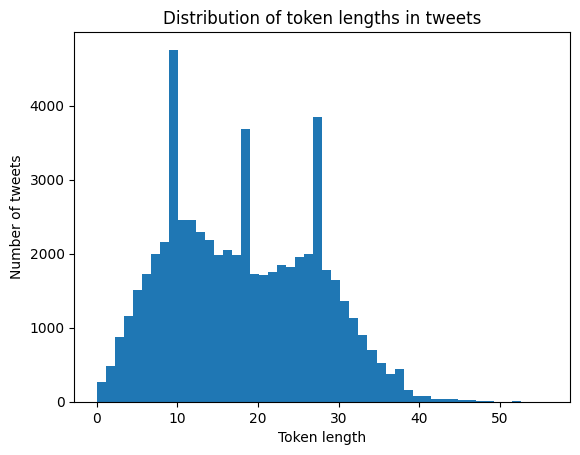

In [46]:
tokenizer = get_tokenizer("basic_english")
token_lengths = list()

# Tokenizing each tweet and storing their length in a list to plot hist
for tweet in new_df['Tweet']:
    tokens = tokenizer(tweet)
    token_lengths.append(len(tokens))

plt.hist(token_lengths, bins=50)
plt.xlabel('Token length')
plt.ylabel('Number of tweets')
plt.title('Distribution of token lengths in tweets')
plt.show()

#### Analysing the histogram, we can say(guess) that almost more than 95% of tweets have token length less than 40. So 40 it is!! - Max Seq Length

### Using 40 as max seq length and creating the Dataset objects for train, test and validation.

In [47]:
max_seq_len = 40

def tokenize_iter(tweets, tokenizer):
    for tweet in tweets:
        yield tokenizer(tweet)
        
vocab = build_vocab_from_iterator(tokenize_iter(new_df['Tweet'], tokenizer), specials=["<unk>", "<pad>"], min_freq=1)
vocab.set_default_index(vocab["<unk>"])

train_dataset = OurSentimentDataset(train_df, tokenizer, vocab, max_seq_len)

### What about the vocab size ??

In [48]:
len(train_dataset.vocab)

48975

### We will only use the words that occures more than 5 times in our dataset. We only apply this to training set. It should be able to handle OOV(out of vocabulary words) in test and validation.

In [49]:
vocab = build_vocab_from_iterator(tokenize_iter(new_df['Tweet'], tokenizer), specials=["<unk>", "<pad>"], min_freq=5)
vocab.set_default_index(vocab["<unk>"])

train_dataset = OurSentimentDataset(train_df, tokenizer, vocab, max_seq_len)
val_dataset = OurSentimentDataset(val_df, tokenizer, vocab, max_seq_len)
test_dataset = OurSentimentDataset(test_df, tokenizer, vocab, max_seq_len)

In [50]:
vocab_size = len(train_dataset.vocab)
vocab_size

11585

#### We have significantly decreased our vocab size for training set.

## Data Loaders

In [56]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Confirming the shape of dataloaders inputs are as expected!!

In [57]:
first_batch = next(iter(train_dataloader))

input_ids_shape = first_batch['tweets_tokenized_ids'].shape
attention_mask_shape = first_batch['padding_mask'].shape
labels_shape = first_batch['sentiment_labels'].shape

input_ids_shape, attention_mask_shape, labels_shape

(torch.Size([32, 40]), torch.Size([32, 40]), torch.Size([32]))

#### As expected, the shapes are [batch_size x max_len] for input ids and attention mask. [batch_size] for labels.

# Test

In [58]:
token_embedding = TokenEmbeddingLayer(embedding_dim=18, num_embeddings=vocab_size)
positional_encoding = SinusoidalPositionalEncoding(pe_dimensions=18, max_seq_len=40)
for batch in train_dataloader:
    input_ids = batch['tweets_tokenized_ids'] 
    token_embeddings = token_embedding(input_ids)
    embeddings_with_pos = positional_encoding(token_embeddings)
    print(embeddings_with_pos.shape)
    break  

torch.Size([32, 40, 18])
